In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import pandas as pd
import translation
import ribosomesimulator
from elongation.concentrations_generator import plot_matrix, make_concentrations
from CodOpY.analyse import translate
import pickle
import numpy as np

In [148]:
def make_matrix(tRNAs, codons, verbose=False):
    """
    Given a DataFrame with tRNA concentrations, and another DataFrame with codons information, generates a decoding matrix

    TRNAs: DataFrame with the tRNAs: anticodon, gene.copy.number
    Codons: DataFrame with the codons to be used
    """
    # check if tRNAs have 'anticodon' column
    if 'anticodon' not in tRNAs.columns:
        print('tRNA list must contain a column named "anticodon".')
        return
    # check if codons have 'codon' column
    if 'codon' not in codons.columns:
        print('Codon list must contain a column named "codon".')
        return

    def first_WC(codon, tRNA):
        codon_nt = codon[0] # first character
        tRNA_nt = tRNA[2] # third character
        return (codon_nt == "A" and tRNA_nt == "U") or (codon_nt == "C" and tRNA_nt == "G") or \
               (codon_nt == "G" and tRNA_nt == "C") or (codon_nt == "U" and tRNA_nt == "A")

    def second_WC(codon, tRNA):
        codon_nt = codon[1] # second character
        tRNA_nt = tRNA[1] # second character
        return (codon_nt == "A" and tRNA_nt == "U") or (codon_nt == "C" and tRNA_nt == "G") or \
               (codon_nt == "G" and tRNA_nt == "C") or (codon_nt == "U" and tRNA_nt == "A")

    def third_WC(codon, tRNA):
        codon_nt = codon[2] # third character
        tRNA_nt = tRNA[0] # first character
        return (codon_nt == "A" and tRNA_nt in ['U','&','3','1','~','N','S',')','{','V','}','P']) or \
                (codon_nt == "C" and tRNA_nt in ['G','#','W']) or \
                (codon_nt == "G" and tRNA_nt in ['C','B']) or (codon_nt == "U" and tRNA_nt in ['A'])

    def first_wobble(codon, tRNA):
        codon_nt = codon[0] # first character
        tRNA_nt = tRNA[2] # third character
        return (codon_nt == "A" and tRNA_nt in ['A']) or \
                (codon_nt == "C" and tRNA_nt in ['A','U']) or \
                (codon_nt == "G" and tRNA_nt in ['A','U']) or \
                (codon_nt == "U" and tRNA_nt in ['G','U'])

    def third_wobble(codon, tRNA):
        codon_nt = codon[2] # third character
        tRNA_nt = tRNA[0] # first character
        return (codon_nt == "A" and tRNA_nt in ['A','I','M','?']) or \
                (codon_nt == "C" and tRNA_nt in ['A','U','P','I','?','Q']) or \
                (codon_nt == "G" and tRNA_nt in ['A','U','&','3','1','~','N','S',')','{','V','P','?','M']) or \
                (codon_nt == "U" and tRNA_nt in ['G','#','W','U','V','P','I','Q'])

    cognate_WC_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    cognate_wobble_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    nearcognate_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    
    if verbose:
        print("Populating WC matrix...")
    # populate cognate WC matrix if WC criteria matched
    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            codon = codons.codon[m]
            anticodon = tRNAs.anticodon[n]
            if second_WC(codon, anticodon) and first_WC(codon, anticodon) and third_WC(codon, anticodon):
                cognate_WC_matrix[n, m] = 1
    if verbose:
        print("done.")
        print("Populating wobble matrix...")
        
    
    #populate cognate wobble matrix if wobble criteria matched, amino acid is correct, and WC matrix entry is 0
    #if incorrect amino acid, assign to near-cognates

    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            codon = codons.codon[m]
            anticodon = tRNAs.anticodon[n]
            if cognate_WC_matrix[n,m] == 0 and second_WC(codon, anticodon) and first_WC(codon, anticodon) and third_wobble(codon, anticodon):
                if tRNAs["three.letter"][n] == codons["three.letter"][m]:
                    cognate_wobble_matrix[n,m] = 1
                else:
                    nearcognate_matrix[n,m] = 1  

    if verbose:
        print('done.')
        print('Populating nearcognate matrix...')

    #populate near-cognate matrix if:
    #wobble and WC matrix entries are 0,
    #wobble criteria are matched

    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            if (cognate_WC_matrix[n,m] == 0 and cognate_wobble_matrix[n,m] == 0) and (second_WC(codons.codon[m],tRNAs.anticodon[n]) and \
                 (first_wobble(codons.codon[m],tRNAs.anticodon[n]) or first_WC(codons.codon[m],tRNAs.anticodon[n])) and\
                 (third_wobble(codons.codon[m],tRNAs.anticodon[n]) or third_WC(codons.codon[m],tRNAs.anticodon[n])) ):
                nearcognate_matrix[n,m] = 1

    if verbose:
        print('done.')

    #Sanity checks

    #Check whether any tRNA:codon combination is assigned 1 in more than one table (this should not occur)

    testsum = cognate_WC_matrix + cognate_wobble_matrix + nearcognate_matrix
    if np.any(testsum>1):
      print('Warning: multiple relationships for identical tRNA:codon pairs detected.')
      return {}
    elif verbose:
      print('No threesome errors detected.')

    return {"cognate.wc.matrix":cognate_WC_matrix, "cognate.wobble.matrix":cognate_wobble_matrix, "nearcognate.matrix":nearcognate_matrix}

In [48]:
def time_seq(input_seq,ref_table):
    '''time_seq calculates the time it takes to decode a DNA or RNA sequence.

    Parameters
    ----------
    input_seq : str
        The DNA or RNA sequence for which the tiem properties are beiing returned.
    ref_table : str
        The name of the reference table to be used, eg 'Scer' for S. cerevisiae

    Returns
    -------
    dict
        A dictionary containing the overall Decoding time in seconds,
        the Average decoding time per codon in seconds, and the CV
        (coefficient of variation of the decoding time per codon)
    '''

    #convert the input sequence to DNA if RNA
    input_seq = input_seq.replace('U','T')
    #make a look-up dictionary of the decoding times available for an amino acid
    #from the reference table
    ref_table['codon'] = ref_table['codon'].str.replace('U','T')
    time_dict_by_codon = dict(zip(ref_table['codon'], ref_table['decoding.time']))
    #add pseudo data for stop codons
    time_dict_by_codon['TGA'] = 0
    time_dict_by_codon['TAA'] = 0
    time_dict_by_codon['TAG'] = 0
    #calculate the decoding time properties of the sequence
    codon_seq = [input_seq[n:n+3] for n in range(0,len(input_seq),3)]
    times_vec = [time_dict_by_codon[codon] for codon in codon_seq]
    results = {}
    results['Decoding time'] = np.sum(times_vec)
    results['Average decoding time per codon'] = results['Decoding time'] / len(codon_seq)
    results['CV'] = np.std(times_vec, ddof=1) / np.mean(times_vec) * 100
    return results

In [14]:
tRNAs = pd.read_csv('Scer_tRNAs.csv')
codons = pd.read_csv('codons.csv')
Scer_matrices = make_matrix(tRNAs,codons)
Scer_concentrations = make_concentrations(Scer_matrices,tRNAs,codons,concentration_col_name='gene.copy.number')
Scer_concentrations.to_csv("Scer_concentrations.csv")

using: gene.copy.number


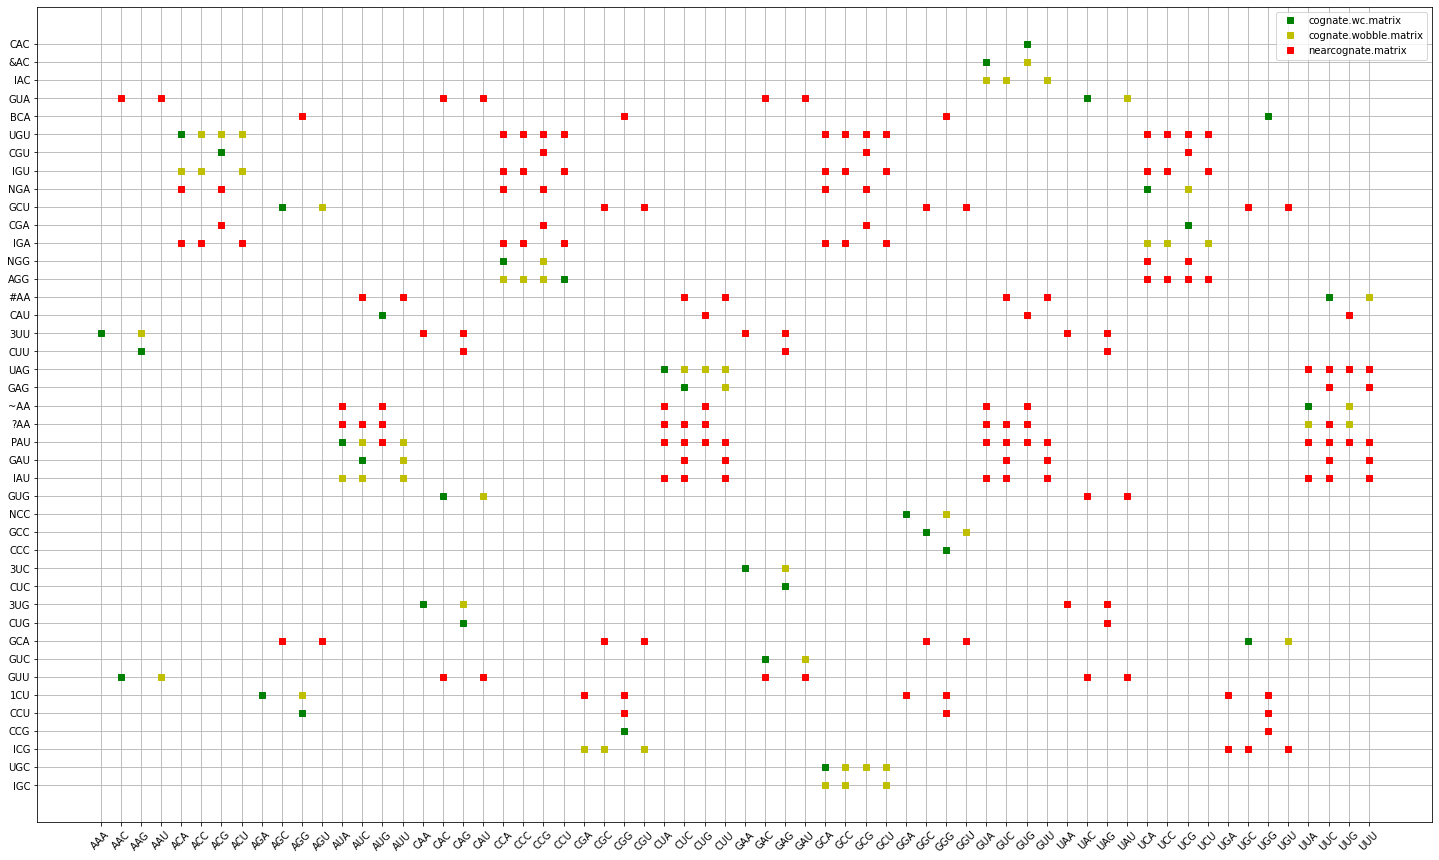

In [25]:
plot_matrix(Scer_matrices,tRNAs,codons)

In [28]:
#evaluate whether all codons can be decoded
print('Undecoded codons:')
for  row in range(Scer_concentrations.shape[0]):
    if sum([Scer_concentrations.iloc[row,2],Scer_concentrations.iloc[row,3]]) == 0:
        print(Scer_concentrations.iloc[row,0] + ': ' + translate(Scer_concentrations.iloc[row,0].replace('U','T')))

Undecoded codons:
UAA: *
UAG: *
UGA: *


In [32]:
#prepare reference list of codons to be simulated
codons = []
nts = ['A','C','G','U']
for nt1 in nts:
    for nt2 in nts:
        for nt3 in nts:
            codon=(nt1+nt2+nt3)
            if codon not in ['UAA','UGA','UAG']:
                codons.append(codon)

Scer_times = []
for codon in codons:
    sim = ribosomesimulator.ribosomesimulator()
    sim.loadConcentrations('Scer_concentrations.csv')
    sim.setCodonForSimulation(codon)
    Scer_times.append(sim.run_repeatedly_get_average_time(10000))

In [127]:
decoding_times_table =  pd.DataFrame({'codon': codons, 'decoding.time': Scer_times})
decoding_times_table.head()

,codon,decoding.time
0,AAA,0.033979
1,AAC,0.077685
2,AAG,0.099130
3,AAU,0.278008
4,ACA,0.225861


In [145]:
EMBO_times_table = pd.read_csv('Scer_decoding_times_EMBOJ.csv')
EMBO_times_table = EMBO_times_table.drop(EMBO_times_table[EMBO_times_table['codon'] == 'UAA'].index)
EMBO_times_table = EMBO_times_table.drop(EMBO_times_table[EMBO_times_table['codon'] == 'UAG'].index)
EMBO_times_table = EMBO_times_table.drop(EMBO_times_table[EMBO_times_table['codon'] == 'UGA'].index)
EMBO_times_table.head()

,codon,decoding.time
0,AAA,0.052
1,AAC,0.121
2,AAG,0.071
3,AAU,0.135
4,ACA,0.390


In [146]:
EMBO_times_table.shape

(61, 2)

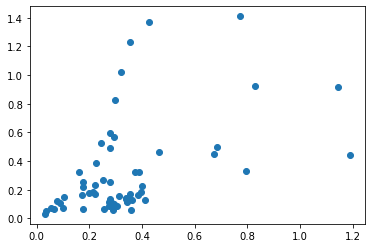

In [147]:
fig,ax = plt.subplots()
ax.scatter(decoding_times_table['decoding.time'],EMBO_times_table['decoding.time'])
plt.show()

In [73]:
#read in sequences
sequences = {}
for record in SeqIO.parse("Figure 2 sequences.txt", "fasta"):
    sequences[record.id] = str(record.seq)

In [115]:
#simulate each sequence and record the average decoding time for this sequence
mean_decoding_speeds = {}

for key,sequence in sequences.items():
    mean_decoding_speeds[key] = 1/time_seq(sequence,decoding_times_table)['Average decoding time per codon']

In [117]:
mean_decoding_speeds

{'MinCFLuc': 2.6075959902085772,
 'StaCFLuc': 3.3881702715006923,
 'MaxCFLuc': 4.980247639900293,
 'minHIS3': 2.8959727037191905,
 'staHIS3': 3.2937429141036505,
 'maxHIS3': 4.088501962405507,
 'minRLuc': 2.930090059506751,
 'staRLuc': 3.642876550283813,
 'maxRLuc': 4.403797551424032,
 'staGLuc': 3.6408369560959586,
 'optGLuc': 4.408962547252609,
 'mCherryv3': 4.242506888796505,
 'mCherryv4': 4.722550630062443,
 'minGST': 2.761802878430068,
 'maxGST': 4.689781313234165}

In [118]:
groups = [['StaCFLuc','MinCFLuc','MaxCFLuc'],['staHIS3','minHIS3','maxHIS3'],['staRLuc','minRLuc','maxRLuc'],['staGLuc','optGLuc'],['mCherryv3','mCherryv4'],['minGST','maxGST']]
group_names = ['CFLuc','HIS3','RLuc','GLuc','mCherry','GST']
len(groups) == len(group_names)


True

In [120]:
this_y = 1
x,y,yticks = [],[],[]
for group_no in range(len(groups)):
    base = groups[group_no][0]
    for sample in groups[group_no][1:]:
        x.append((mean_decoding_speeds[sample] /mean_decoding_speeds[base]))
        y.append(this_y)
    yticks.append(group_names[group_no])
    this_y += 1

C:\Users\Tvon-\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


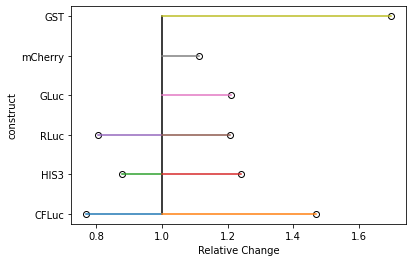

In [121]:
fig,ax = plt.subplots()
ax.plot((1,1),(1,6),color='black')
for p in range(len(y)):
    ax.plot((1,x[p]),(y[p],y[p]))
    ax.scatter(x[p],y[p], color='white', edgecolors='black')
ax.set_xlabel('Relative Change')
ax.set_ylabel('construct')
ax.set_yticklabels([''] + yticks)
plt.show()

In [124]:

#simulate each sequence and record the average decoding time for this sequence
mean_decoding_speeds = {}

for key,sequence in sequences.items():
    mean_decoding_speeds[key] = 1/time_seq(sequence,EMBO_times_table)['Average decoding time per codon']

In [125]:
this_y = 1
x,y,yticks = [],[],[]
for group_no in range(len(groups)):
    base = groups[group_no][0]
    for sample in groups[group_no][1:]:
        x.append((mean_decoding_speeds[sample] /mean_decoding_speeds[base]))
        y.append(this_y)
    yticks.append(group_names[group_no])
    this_y += 1

C:\Users\Tvon-\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


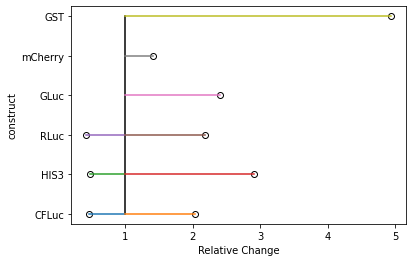

In [126]:
fig,ax = plt.subplots()
ax.plot((1,1),(1,6),color='black')
for p in range(len(y)):
    ax.plot((1,x[p]),(y[p],y[p]))
    ax.scatter(x[p],y[p], color='white', edgecolors='black')
ax.set_xlabel('Relative Change')
ax.set_ylabel('construct')
ax.set_yticklabels([''] + yticks)
plt.show()

In [7]:
sim = translation.translation()
sim.loadConcentrations("Scer_concentrations.csv")
sim.setInitiationRate(1)
sim.setTerminationRate(100)
sim.setFinishedRibosomes(1000)
sim.setHistorySize(10000000)
sim.inputMRNA(sequences['StaCFLuc'])
sim.run()


In [8]:
sim.elongations_durations

([164.63218244467447,
  177.06331646043333,
  183.44924813827606,
  186.0136432882897,
  181.85138513452853,
  186.91194621647375,
  190.98459236021716,
  195.42470438978077,
  194.9879712151075,
  194.30533670452482,
  196.830563396419,
  195.61888039599012,
  195.5981483371659,
  198.68377210122168,
  196.98181912491074,
  202.5948956489768,
  200.80865783194375,
  200.7901935794122,
  204.79180803344113,
  207.15308412883857,
  208.1894037608471,
  212.17343111950268,
  207.50617089051096,
  209.6101187798014,
  206.7853773931362,
  210.8531349432669,
  213.59417024049472,
  212.35131066490186,
  217.30698975714512,
  215.97799186162038,
  219.06917799939671,
  220.95751297487524,
  224.58006798419163,
  227.35108079219145,
  223.9408771583245,
  225.58695432767612,
  225.84670233943748,
  227.1938621064952,
  225.10655576136656,
  226.64618646722053,
  228.2248656676339,
  227.77830884488145,
  225.07520774844502,
  224.42355730347919,
  220.86093655627988,
  223.2454352703705,
  2